# Logistic Regression

This notebook presents a comprehensive workflow for optimizing a logistic regression model to detect breast cancer from clinical features. The process includes systematic dataset preprocessing, feature selection, and multi-stage hyperparameter optimization using cross-validation and MLflow tracking. Emphasis is placed on maximizing recall to minimize false negatives, which is critical in medical diagnostics. The methodology combines randomized and grid search strategies, mutual information analysis for hyperparameter impact, and rigorous evaluation of model performance. The resulting model achieves high recall, f1, and roc-auc, demonstrating robust generalization and suitability for clinical application.

## Setup

In [1]:
import os
import warnings
import random
import itertools
from typing import Any, Dict, List

import joblib
from tqdm import tqdm
import mlflow
import numpy as np
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)
from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split,
    cross_validate,
)
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OrdinalEncoder

In [2]:
# Suppress warnings from Python's multiprocessing module. This is a known issue on Apple Silicon Macs. It does not affect the code's functionality.
warnings.filterwarnings(
    "ignore", category=UserWarning, module="multiprocessing.resource_tracker"
)

In [3]:
mlflow.set_tracking_uri(os.path.join(os.path.dirname(os.getcwd()), "mlruns"))

### Helper Functions

- **sample_param_combinations**: Randomly samples a specified number of hyperparameter combinations from a parameter grid for efficient randomized search.

- **all_param_combinations**: Generates all possible hyperparameter combinations from a parameter grid using a cartesian product, supporting exhaustive grid search.

- **total_param_combinations**: Calculates the total number of possible hyperparameter combinations in a given parameter grid.

In [4]:
def sample_param_combinations(
    param_grid: Dict[str, Any], n_iter: int = 50, seed: int = 42
) -> List[Dict[str, Any]]:
    """
    Sample parameter combinations from a given parameter grid.

    Args:
        param_grid (dict): Dictionary of parameter names and their possible values.
        n_iter (int): Number of combinations to sample.
        seed (int): Random seed for reproducibility.

    Returns:
        list[dict]: List of sampled parameter combinations.
    """

    random.seed(seed)

    all_keys = list(param_grid.keys())
    all_values = [param_grid[k] for k in all_keys]

    all_combos = list(itertools.product(*all_values))

    random.shuffle(all_combos)
    sampled_combos = all_combos[:n_iter]

    return [dict(zip(all_keys, values)) for values in sampled_combos]

In [5]:
def all_param_combinations(param_grid: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Generate every possible hyperparameter combination from a parameter grid using cartesian product.

    Args:
        param_grid (Dict[str, Any]): Mapping of parameter names to iterables of possible values.

    Returns:
        (List[Dict[str, Any]]): A list of dicts, each representing one unique combination of parameters.
    """
    keys = list(param_grid.keys())
    values_lists = [param_grid[k] for k in keys]

    all_combos = itertools.product(*values_lists)

    return [dict(zip(keys, combo)) for combo in all_combos]

In [6]:
def total_param_combinations(param_grid: Dict[str, Any]) -> int:
    """
    Calculate the total number of possible hyperparameter combinations.

    Args:
        param_grid(dict) : Dictionary of parameter names to lists of possible values.

    Returns:
        int: Total number of combinations.
    """

    total = 1
    for values in param_grid.values():
        total *= len(values)

    return total

## Dataset Selection

To determine the best preprocessing strategy for binary classification of breast cancer data, multiple pipelines will be evaluated. These pipelines vary by scaling method—Power Transformer (PT), Quantile Transformer (QT), MinMaxScaler, and StandardScaler (STD)—and by feature selection method: none (`all`), mutual information (`mi`), and sequential feature selection (`sfs`). The primary performance metric will be **recall**, given the critical nature of detecting positive (cancerous) cases. Secondary metrics include F1-score, accuracy, precision, and ROC AUC.

**Metric Importance Ranking**
1. Recall
    * Why: Missing a cancer case (false negative) can be life-threatening, so recall must be prioritized to catch as many actual positives as possible.

2. ROC AUC
    * Why: Provides an overall measure of classification quality across all thresholds, important when dealing with imbalanced data.

3. F1 Score
    * Why: Balances recall and precision, useful when both false positives and false negatives matter, but especially when class distribution is uneven. False positives are not as grave as false negative but should also be reduced as much as possible (without sacrificing recall), to avoid unnecessary secondary testing.

4. Precision
    * Why: Important to reduce false positives, but secondary to recall in medical contexts.

5. Accuracy
    * Why: Can be misleading in imbalanced datasets, where high accuracy might still mean missing many positive cases.

In [9]:
# Get all versions of preprocessed data
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_data")
files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f))]
files

['processed_data_pt_mi.parquet',
 'processed_data_std_sfs.parquet',
 'processed_data_std_mi.parquet',
 'processed_data_minmax_sfs.parquet',
 'processed_data_minmax_all.parquet',
 'processed_data_std_all.parquet',
 'processed_data_qt_mi.parquet',
 'processed_data_pt_sfs.parquet',
 'processed_data_qt_all.parquet',
 'processed_data_minmax_mi.parquet',
 'processed_data_qt_sfs.parquet',
 'processed_data_pt_all.parquet']

In [5]:
mlflow.set_experiment(experiment_name="LR-Dataset_Selection")

2025/05/20 15:10:24 INFO mlflow.tracking.fluent: Experiment with name 'LR-Dataset_Selection' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/jonas/git/ml_project/mlruns/864561007828072332', creation_time=1747746624622, experiment_id='864561007828072332', last_update_time=1747746624622, lifecycle_stage='active', name='LR-Dataset_Selection', tags={}>

In [ ]:
# Default hyperparameters will be used for dataset selection
params = {
    "penalty": "l2",
    "dual": False,
    "tol": 1e-4,
    "C": 1.0,
    "fit_intercept": True,
    "intercept_scaling": 1.0,
    "class_weight": None,
    "solver": "lbfgs",
    "max_iter": 100,
    "warm_start": False,
    "l1_ratio": None,
}

best_dataset = None
best_score = 0.0
best_run = None

for i, file in enumerate(tqdm(files, desc="Processing ML Runs")):

    # Load and split data
    df = pd.read_parquet(os.path.join(data_path, file))
    X = df.drop("Diagnosis", axis=1)
    y = df["Diagnosis"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.8, test_size=0.2, random_state=42
    )

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Dataset Selection",
                "Dataset": file,
            }
        )

        mlflow.log_params(params)

        # Create and train model
        model = LogisticRegression(n_jobs=-1, random_state=42, verbose=0, **params)
        model.fit(X_train, y_train)

        # Get predictions
        y_pred_train = model.predict(X_train)
        y_prob_train = model.predict_proba(X_train)[:, 1]
        y_pred_test = model.predict(X_test)
        y_prob_test = model.predict_proba(X_test)[:, 1]

        # Calculate and log metrics
        mlflow.log_metrics(
            {
                "accuracy_train": float(
                    accuracy_score(y_true=y_train, y_pred=y_pred_train)
                ),
                "precision_train": float(
                    precision_score(y_true=y_train, y_pred=y_pred_train)
                ),
                "recall_train": float(
                    recall_score(y_true=y_train, y_pred=y_pred_train)
                ),
                "f1_train": float(f1_score(y_true=y_train, y_pred=y_pred_train)),
                "roc_auc_train": float(
                    roc_auc_score(y_true=y_train, y_score=y_prob_train)
                ),
                "accuracy_test": float(
                    accuracy_score(y_true=y_test, y_pred=y_pred_test)
                ),
                "precision_test": float(
                    precision_score(y_true=y_test, y_pred=y_pred_test)
                ),
                "recall_test": float(recall_score(y_true=y_test, y_pred=y_pred_test)),
                "f1_test": float(f1_score(y_true=y_test, y_pred=y_pred_test)),
                "roc_auc_test": float(
                    roc_auc_score(y_true=y_test, y_score=y_prob_test)
                ),
            }
        )

        input_example = X_train.iloc[:5]

        mlflow.sklearn.log_model(model, "model", input_example=input_example)

        # Check if current model performs better than current best model
        if best_score < recall_score(y_true=y_test, y_pred=y_pred_test):
            best_score = recall_score(y_true=y_test, y_pred=y_pred_test)
            best_dataset = file
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()

print("")
print(f"Best dataset: {best_dataset}")
print(f"Best score: {best_score}")
print(f"Best run: {best_run}")

Processing ML Runs: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Best dataset: processed_data_pt_sfs.parquet
Best score: 0.7368421052631579
Best run: c100974268ed427cbc671cfd9d903ac2


In [6]:
# Get data from runs
runs_metadata = mlflow.search_runs(experiment_names=["LR-Dataset_Selection"])
runs_metadata = runs_metadata[
    sorted(
        [
            "metrics.f1_test",
            "metrics.roc_auc_test",
            "metrics.precision_train",
            "metrics.precision_test",
            "metrics.roc_auc_train",
            "metrics.recall_test",
            "metrics.recall_train",
            "metrics.accuracy_test",
            "metrics.accuracy_train",
            "metrics.f1_train",
            "tags.Dataset",
        ]
    )
]  # type: ignore
runs_metadata["tags.Dataset"] = runs_metadata["tags.Dataset"].apply(
    lambda x: str(x).replace("processed_data_", "").replace(".parquet", "")
)
runs_metadata.columns = [
    col.split(".")[1] if "." in col else col for col in runs_metadata.columns
]
runs_metadata

,accuracy_test,accuracy_train,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train,roc_auc_test,roc_auc_train,Dataset
0,0.851485,0.9050,0.782609,0.866197,0.870968,0.872340,0.710526,0.860140,0.925647,0.963538,pt_all
1,0.831683,0.8850,0.760563,0.839161,0.818182,0.839161,0.710526,0.839161,0.912281,0.952600,qt_sfs
2,0.742574,0.8050,0.551724,0.651786,0.800000,0.901235,0.421053,0.510490,0.868421,0.909553,minmax_mi
3,0.831683,0.8875,0.760563,0.842105,0.818182,0.845070,0.710526,0.839161,0.916458,0.953199,qt_all
4,0.861386,0.9050,0.800000,0.868056,0.875000,0.862069,0.736842,0.874126,0.925647,0.963702,pt_sfs
5,0.792079,0.8900,0.720000,0.843972,0.729730,0.856115,0.710526,0.832168,0.889724,0.941362,qt_mi
6,0.811881,0.8925,0.707692,0.837736,0.851852,0.909836,0.605263,0.776224,0.876775,0.951892,std_all
7,0.752475,0.8225,0.561404,0.687225,0.842105,0.928571,0.421053,0.545455,0.878028,0.927621,minmax_all
8,0.762376,0.8225,0.571429,0.675799,0.888889,0.973684,0.421053,0.517483,0.865079,0.925227,minmax_sfs
9,0.772277,0.8850,0.646154,0.827068,0.777778,0.894309,0.552632,0.769231,0.901003,0.948328,std_mi


In [ ]:
# Get available metrics
metrics = [c for c in runs_metadata.columns if "Dataset" not in c]  # type: ignore
metrics

['accuracy_test',
 'accuracy_train',
 'f1_test',
 'f1_train',
 'precision_test',
 'precision_train',
 'recall_test',
 'recall_train',
 'roc_auc_test',
 'roc_auc_train']

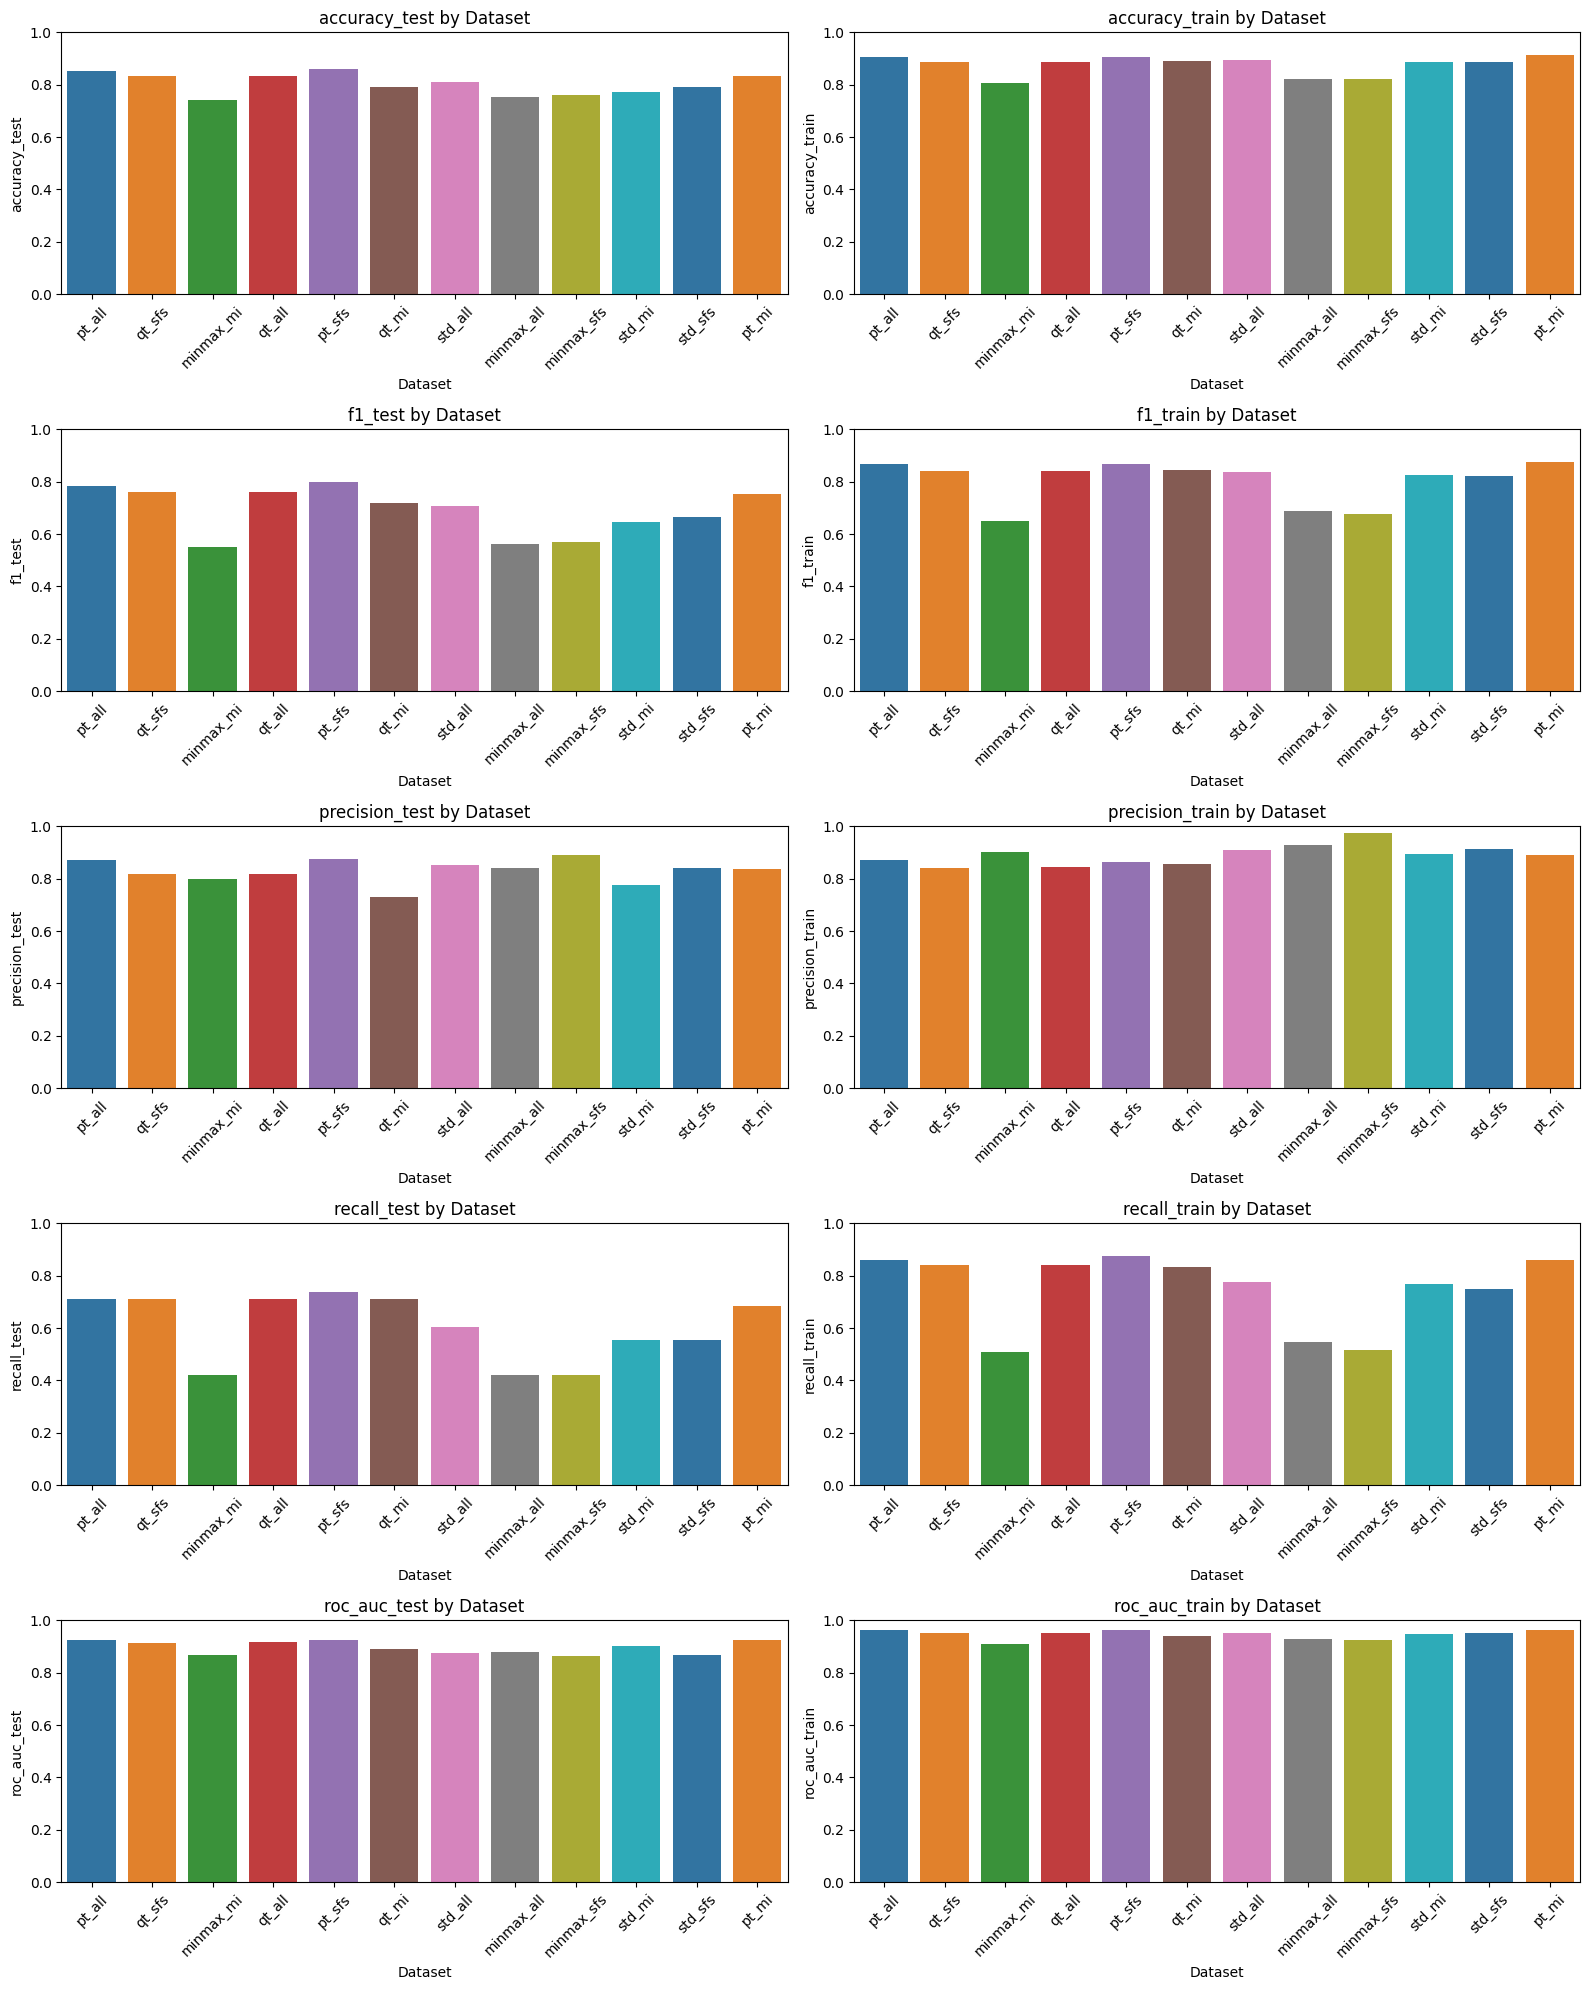

In [ ]:
# Plot metrics
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))
axes = axes.flatten()

palette = sns.color_palette("tab10", n_colors=runs_metadata["Dataset"].nunique())  # type: ignore

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sns.barplot(
        x="Dataset", y=metric, data=runs_metadata, hue="Dataset", ax=ax, palette=palette  # type: ignore
    )
    ax.set_xlabel("Dataset")
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} by Dataset")
    ax.set_ylim(0.0, 1.0)
    ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()

plt.show()

* **Best Recall**:
  The highest test recall (0.7368) was achieved by the `pt_sfs` dataset (Power Transformer + SFS), closely followed by `pt_all` and others in the PT and QT families.

* **Best Overall Balance**:
  `pt_sfs` not only had the best recall but also maintained high scores in:

  * Accuracy (0.8614)
  * F1-score (0.8000)
  * Precision (0.8750)
  * ROC AUC (0.9256)

* **Underperformers**:
  All `minmax` variants significantly underperformed in recall (0.4211), indicating that MinMaxScaler is not a suitable preprocessing method for this task.

* **StandardScaler Performance**:
  While `std_all` and its variants offered reasonable performance, they did not surpass the PT or QT transformations in any major metric.

* **Overfitting Consideration**:
  The PT and QT models show a consistent train-test performance gap, though not alarmingly high. `pt_sfs` has a recall of 0.7368 on test vs. 0.8741 on train, which is acceptable given the improved generalization.

Based on the evaluation, **`pt_sfs` (Power Transformer + Sequential Feature Selection)** is the best preprocessing setup for this task. It offers the highest recall with strong support from other metrics, making it a reliable choice for a classification problem where identifying all positive cases is critical.

In [ ]:
# Get scores of best run
runs_metadata[runs_metadata["Dataset"] == "pt_sfs"]  # type: ignore

,accuracy_test,accuracy_train,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train,roc_auc_test,roc_auc_train,Dataset
4,0.861386,0.905,0.8,0.868056,0.875,0.862069,0.736842,0.874126,0.925647,0.963702,pt_sfs


## Hyperparameter Optimization

To systematically find the best hyperparameter configuration, a three-step optimization strategy will be used:

* Broad Exploration (Randomized Search)
* Focused Tuning (Grid Search)
* Fine Adjustment (Grid Search)

This staged approach ensures a balance between exploration of the full parameter space and exploitation of the most promising regions, while being mindful of computational efficiency.

Cross-validation is used because it provides a reliable estimate of model generalization and guides robust hyperparameter tuning by averaging performance metrics over multiple train–test splits.

In order to properly understand which hyperparameters have the highest impact on the main target metrics and thus should be inspected deeper, `mutual information` is used.

### Setup

In [7]:
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning,ignore::RuntimeWarning"

In [8]:
mlflow.set_experiment(experiment_name="LR-Hyperparameter_Optimization")

<Experiment: artifact_location='/Users/jonas/git/ml_project/mlruns/166928110039040565', creation_time=1748025393932, experiment_id='166928110039040565', last_update_time=1748025393932, lifecycle_stage='active', name='LR-Hyperparameter_Optimization', tags={}>

In [9]:
# Load and split data
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_data")
df = pd.read_parquet(os.path.join(data_path, "processed_data_pt_sfs.parquet"))
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=42
)

In [10]:
# Prepare CV and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(recall_score)

In [11]:
# Define scoring functions
scoring = {
    "recall": "recall",
    "precision": "precision",
    "f1": "f1",
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
}

### Broad Hyperparameter Exploration

The first step aims to broadly sample the hyperparameter space to identify regions where the model performs well. Rather than exhaustively trying all combinations (which is computationally expensive), randomized sampling will be used to cover more ground quickly.

**Parameters:**
* penalty: Type of regularization (l1, l2, elasticnet, or None).
* tol: Tolerance for stopping criteria.
* C: Inverse of regularization strength, sampled on a log scale.
* solver: Optimization algorithm.
* fit_intercept: Whether to fit the intercept.
* max_iter: Number of iterations before solver termination.
* class_weight: Option to balance classes, which can help boost recall.
* warm_start: Whether to reuse the solution of the previous call to fit as initialization.
* l1_ratio: Elastic Net mixing parameter, relevant only for penalty='elasticnet'.

Starting with a broad search allows for:
* Discovery of effective combinations that might be missed in a narrowly defined grid.
* Understanding which hyperparameters have the most influence on model performance.
* Avoiding overfitting to a local minimum early in the optimization process.

The insights from this step guide the design of a more focused and efficient search in the next phase.

A custom implementation of random search will be used for integration with mlflow.

Certain hyperparameter combinations will cause errors, thus multiple valid parameter grids will be defined and tested in as much runs.

#### Run 1

The first set of runs focuses on hyperparameter combinations that can use `l2` as the penalty term.

In [22]:
# Define the parameter grid - penalty=l2
param_grid = {
    "penalty": ["l2"],
    "tol": [1e-4, 1e-3, 1e-2, 1e-1],
    "C": np.logspace(-4, 4, 20),
    "solver": [
        "lbfgs",
        "liblinear",
        "saga",
        "newton-cg",
        "newton-cholesky",
        "sag",
        "saga",
    ],
    "fit_intercept": [True, False],
    "max_iter": [100, 200, 500, 1000, 10000],
    "class_weight": [None, "balanced"],
    "warm_start": [False, True],  # Useless when using liblinear solver
}

param_samples = sample_param_combinations(param_grid, n_iter=5000)
print(
    "Number of total possible parameter combinations: ",
    total_param_combinations(param_grid),
)
print("Number of sampled parameter combinations: ", len(param_samples))
print("")
print(param_samples[0])

Number of total possible parameter combinations:  22400
Number of sampled parameter combinations:  5000

{'penalty': 'l2', 'tol': 0.001, 'C': np.float64(3792.690190732246), 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 1000, 'class_weight': 'balanced', 'warm_start': False}


In [28]:
# Suppress warnings for convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

best_score = -np.inf
best_run = None
best_params = None

for i, params in enumerate(tqdm(param_samples, desc="Processing ML Runs")):

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Hyperparameter Optimization",
                "Dataset": "processed_data_pt_sfs.parquet",
            }
        )

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = LogisticRegression(verbose=0, random_state=42, n_jobs=1)
        model.set_params(**params)

        # Get model scores
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        mean_scores = {
            f"train_{metric}": np.mean(cv_results[f"train_{metric}"])
            for metric in scoring.keys()
        }
        mean_scores.update(
            {
                f"test_{metric}": np.mean(cv_results[f"test_{metric}"])
                for metric in scoring.keys()
            }
        )

        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)

        # Update best score
        if mean_scores["test_recall"] > best_score:
            best_score = mean_scores["test_recall"]
            best_params = params
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()


print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")
print(f"Best Run: {best_run}")

Processing ML Runs: 100%|██████████| 5000/5000 [08:29<00:00,  9.80it/s]

Best Score: 0.9716748768472907
Best Params: {'penalty': 'l2', 'tol': 0.1, 'C': np.float64(0.00026366508987303583), 'solver': 'sag', 'fit_intercept': True, 'max_iter': 100, 'class_weight': 'balanced', 'warm_start': False}
Best Run: 3a238a280b304db5be5ebc34cac0a845


#### Run 2

The first set of runs focuses on hyperparameter combinations that can use `l1` as the penalty term.

In [38]:
# Define the parameter grid - penalty=l1
param_grid = {
    "penalty": ["l1"],
    "tol": [1e-4, 1e-3, 1e-2, 1e-1],
    "C": np.logspace(-4, 4, 20),
    "solver": ["liblinear", "saga", "saga"],
    "fit_intercept": [True, False],
    "max_iter": [100, 200, 500, 1000, 10000],
    "class_weight": [None, "balanced"],
    "warm_start": [False, True],  # Useless when using liblinear solver
}

param_samples = sample_param_combinations(param_grid, n_iter=5000)
print(
    "Number of total possible parameter combinations: ",
    total_param_combinations(param_grid),
)
print("Number of sampled parameter combinations: ", len(param_samples))
print("")
print(param_samples[0])

Number of total possible parameter combinations:  9600
Number of sampled parameter combinations:  5000

{'penalty': 'l1', 'tol': 0.001, 'C': np.float64(0.08858667904100823), 'solver': 'liblinear', 'fit_intercept': False, 'max_iter': 200, 'class_weight': 'balanced', 'warm_start': True}


In [30]:
# Suppress warnings for convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

best_score = -np.inf
best_run = None
best_params = None

for i, params in enumerate(tqdm(param_samples, desc="Processing ML Runs")):

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Hyperparameter Optimization",
                "Dataset": "processed_data_pt_sfs.parquet",
            }
        )

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = LogisticRegression(verbose=0, random_state=42, n_jobs=1)
        model.set_params(**params)

        # Get model scores
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        mean_scores = {
            f"train_{metric}": np.mean(cv_results[f"train_{metric}"])
            for metric in scoring.keys()
        }
        mean_scores.update(
            {
                f"test_{metric}": np.mean(cv_results[f"test_{metric}"])
                for metric in scoring.keys()
            }
        )

        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)

        # Update best score
        if mean_scores["test_recall"] > best_score:
            best_score = mean_scores["test_recall"]
            best_params = params
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()


print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")
print(f"Best Run: {best_run}")

Processing ML Runs: 100%|██████████| 5000/5000 [17:29<00:00,  4.76it/s]

Best Score: 0.9433497536945812
Best Params: {'penalty': 'l1', 'tol': 0.0001, 'C': np.float64(545.5594781168514), 'solver': 'saga', 'fit_intercept': False, 'max_iter': 500, 'class_weight': 'balanced', 'warm_start': False}
Best Run: 751ff56508864f04a0dd2a829f459cd3


#### Run 3

The first set of runs focuses on hyperparameter combinations that can use `elasticnet` as the penalty term.

In [39]:
# Define the parameter grid - penalty=elasticnet
param_grid = {
    "penalty": ["elasticnet"],
    "tol": [1e-4, 1e-3, 1e-2, 1e-1],
    "C": np.logspace(-4, 4, 20),
    "solver": ["saga"],
    "fit_intercept": [True, False],
    "max_iter": [100, 200, 500, 1000, 10000],
    "class_weight": [None, "balanced"],
    "warm_start": [False, True],  # Useless when using liblinear solver
    "l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0],
}

param_samples = sample_param_combinations(param_grid, n_iter=5000)
print(
    "Number of total possible parameter combinations: ",
    total_param_combinations(param_grid),
)
print("Number of sampled parameter combinations: ", len(param_samples))
print("")
print(param_samples[0])

Number of total possible parameter combinations:  16000
Number of sampled parameter combinations:  5000

{'penalty': 'elasticnet', 'tol': 0.01, 'C': np.float64(0.0006951927961775605), 'solver': 'saga', 'fit_intercept': False, 'max_iter': 500, 'class_weight': None, 'warm_start': True, 'l1_ratio': 0.0}


In [40]:
# Suppress warnings for convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

best_score = -np.inf
best_run = None
best_params = None

for i, params in enumerate(tqdm(param_samples, desc="Processing ML Runs")):

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Hyperparameter Optimization",
                "Dataset": "processed_data_pt_sfs.parquet",
            }
        )

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = LogisticRegression(verbose=0, random_state=42, n_jobs=1)
        model.set_params(**params)

        # Get model scores
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        mean_scores = {
            f"train_{metric}": np.mean(cv_results[f"train_{metric}"])
            for metric in scoring.keys()
        }
        mean_scores.update(
            {
                f"test_{metric}": np.mean(cv_results[f"test_{metric}"])
                for metric in scoring.keys()
            }
        )

        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)

        # Update best score
        if mean_scores["test_recall"] > best_score:
            best_score = mean_scores["test_recall"]
            best_params = params
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()


print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")
print(f"Best Run: {best_run}")

Processing ML Runs: 100%|██████████| 5000/5000 [27:43<00:00,  3.01it/s]

Best Score: 0.9433497536945812
Best Params: {'penalty': 'elasticnet', 'tol': 0.0001, 'C': np.float64(545.5594781168514), 'solver': 'saga', 'fit_intercept': False, 'max_iter': 200, 'class_weight': 'balanced', 'warm_start': False, 'l1_ratio': 0.0}
Best Run: df79d65931d542e491f5bd30fab18297


In [ ]:
# Get data from best runs by recall (and other metrics)
runs_metadata = mlflow.search_runs(experiment_names=["LR-Hyperparameter_Optimization"])
runs_metadata = runs_metadata[
    sorted(
        [
            "metrics.test_f1",
            "metrics.test_roc_auc",
            "metrics.train_precision",
            "metrics.test_precision",
            "metrics.train_roc_auc",
            "metrics.test_recall",
            "metrics.train_recall",
            "metrics.test_accuracy",
            "metrics.train_accuracy",
            "metrics.train_f1",
            "params.fit_intercept",
            "params.C",
            "params.class_weight",
            "params.solver",
            "params.penalty",
            "params.warm_start",
            "params.max_iter",
            "params.tol",
            "params.l1_ratio",
        ]
    )
]  # type: ignore
runs_metadata = runs_metadata.sort_values(
    by=[
        "metrics.test_recall",
        "metrics.test_roc_auc",
        "metrics.test_f1",
        "metrics.train_recall",
        "metrics.train_roc_auc",
        "metrics.train_f1",
        "metrics.test_precision",
        "metrics.test_accuracy",
        "metrics.train_precision",
        "metrics.train_accuracy",
    ],
    ascending=False,
).head(
    100
)  # type: ignore
runs_metadata.columns = [
    col.split(".")[1] if "." in col else col for col in runs_metadata.columns
]
runs_metadata

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,C,class_weight,fit_intercept,l1_ratio,max_iter,penalty,solver,tol,warm_start
10204,0.675,0.689615,0.541048,0.971675,0.926493,0.6650,0.679225,0.533823,0.956278,0.928088,0.00026366508987303583,balanced,True,None,500,l2,sag,0.1,True
14813,0.675,0.689615,0.541048,0.971675,0.926493,0.6650,0.679225,0.533823,0.956278,0.928088,0.00026366508987303583,balanced,True,None,100,l2,sag,0.1,False
11244,0.855,0.827583,0.732723,0.957635,0.966431,0.8600,0.828283,0.737932,0.944027,0.967808,78.47599703514607,balanced,False,None,500,l2,newton-cholesky,0.1,False
12718,0.855,0.827583,0.732723,0.957635,0.966431,0.8600,0.828283,0.737932,0.944027,0.967808,78.47599703514607,balanced,False,None,1000,l2,newton-cholesky,0.1,True
12084,0.855,0.827583,0.732723,0.957635,0.966158,0.8600,0.828245,0.737831,0.944027,0.967817,206.913808111479,balanced,False,None,100,l2,newton-cholesky,0.1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8209,0.860,0.829426,0.744018,0.943350,0.965748,0.8625,0.830567,0.742654,0.942273,0.967443,545.5594781168514,balanced,False,None,1000,l1,saga,0.0001,False
9171,0.860,0.829426,0.744018,0.943350,0.965748,0.8625,0.830567,0.742654,0.942273,0.967443,545.5594781168514,balanced,False,None,10000,l1,saga,0.0001,True
9178,0.860,0.829426,0.744018,0.943350,0.965748,0.8625,0.830567,0.742654,0.942273,0.967443,545.5594781168514,balanced,False,None,200,l1,saga,0.0001,False
9882,0.860,0.829426,0.744018,0.943350,0.965748,0.8625,0.830567,0.742654,0.942273,0.967443,545.5594781168514,balanced,False,None,1000,l1,saga,0.0001,True


In [52]:
# Create a DataFrame to store mutual information scores
mi_scores_df = pd.DataFrame(columns=["feature", "test_recall", "test_roc_auc", "test_f1"])  # type: ignore

main_metrics = ["test_recall", "test_roc_auc", "test_f1"]

hyperparameters = [
    "penalty",
    "C",
    "solver",
    "fit_intercept",
    "max_iter",
    "class_weight",
    "tol",
    "warm_start",
    "l1_ratio",
]

# Iterate over each metric and calculate mutual information scores
for metric in main_metrics:

    X = runs_metadata[hyperparameters].copy()  # type: ignore
    y = runs_metadata[metric]  # type: ignore

    # Encode categorical variables
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X.astype(str))

    mi_scores = mutual_info_regression(X_encoded, y)

    mi_scores_df[metric] = mi_scores
    mi_scores_df["feature"] = X.columns

mi_scores_df = mi_scores_df.sort_values(by=main_metrics, ascending=False)
mi_scores_df

,feature,test_recall,test_roc_auc,test_f1
6,tol,0.509626,0.762341,0.534317
2,solver,0.347469,0.706628,0.359293
0,penalty,0.161953,0.351322,0.060001
4,max_iter,0.119997,0.000000,0.000000
8,l1_ratio,0.097790,0.111444,0.070845
1,C,0.066494,0.704387,0.182688
3,fit_intercept,0.022492,0.016291,0.002822
5,class_weight,0.002570,0.000000,0.000000
7,warm_start,0.000000,0.000000,0.000000


* `tol` shows the highest influence across all three metrics, suggesting that model convergence criteria have a major effect on detecting positive cancer cases.

* `solver` also has a relatively strong impact on all metrics. This implies solver choice significantly affects the classifier’s ability to discriminate between classes.

* `penalty` and `l1_ratio` have moderate influence, suggesting regularization method and strength impact the model’s ability to generalize but are less critical.

* `max_iter` shows some impact on *recall*, but none on *roc_auc* or *f1* — likely due to early convergence or saturation.

* `C` shows weak but non-negligible influence, especially on *roc_auc*.

* `fit_intercept`, `class_weight`, and `warm_start` have very low to zero **mi**, meaning they have minimal impact on performance.

In [57]:
# Get data from the 10 best runs by recall (and other metrics)
top_ten_runs = runs_metadata.head(10)  # type: ignore
top_ten_runs

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,C,class_weight,fit_intercept,l1_ratio,max_iter,penalty,solver,tol,warm_start
10204,0.675,0.689615,0.541048,0.971675,0.926493,0.665,0.679225,0.533823,0.956278,0.928088,0.00026366508987303583,balanced,True,None,500,l2,sag,0.1,True
14813,0.675,0.689615,0.541048,0.971675,0.926493,0.665,0.679225,0.533823,0.956278,0.928088,0.00026366508987303583,balanced,True,None,100,l2,sag,0.1,False
11244,0.855,0.827583,0.732723,0.957635,0.966431,0.860,0.828283,0.737932,0.944027,0.967808,78.47599703514607,balanced,False,None,500,l2,newton-cholesky,0.1,False
12718,0.855,0.827583,0.732723,0.957635,0.966431,0.860,0.828283,0.737932,0.944027,0.967808,78.47599703514607,balanced,False,None,1000,l2,newton-cholesky,0.1,True
12084,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967817,206.913808111479,balanced,False,None,100,l2,newton-cholesky,0.1,True
12802,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967817,206.913808111479,balanced,False,None,100,l2,newton-cholesky,0.1,False
10709,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967800,545.5594781168514,balanced,False,None,100,l2,newton-cholesky,0.1,False
12082,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967800,545.5594781168514,balanced,False,None,100,l2,newton-cholesky,0.1,True
12013,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967800,10000.0,balanced,False,None,10000,l2,newton-cholesky,0.1,True
13880,0.855,0.827583,0.732723,0.957635,0.966158,0.860,0.828245,0.737831,0.944027,0.967800,10000.0,balanced,False,None,200,l2,newton-cholesky,0.1,True


`tol`: All top results used a tolerance of 0.1, the upper bound of the tested range. Given its consistent use in high-performing models, 0.1 will serve as the baseline for further analysis, though variations around this value may still be worth exploring.

`solver`: While *sag* achieved the two top recall scores, the remaining 8/10 top runs used *newton-cholesky*, which provided superior overall metrics with only a marginal recall drop. Thus, *newton-cholesky* is selected for continued optimization.

`penalty`: All top-performing models used *l2 regularization*, confirming its effectiveness for this classification task. It will be fixed as the penalty method in subsequent tuning.

`max_iter`: A broad range of `max_iter` values (100 to 10,000) appears in top results, indicating potential sensitivity. It will be further fine-tuned in future searches.

`l1_ratio`: Not used in top runs due to exclusive use of l2 penalty, which does not require it. This parameter will be excluded moving forward.

`C`: The inverse regularization strength varies widely across top results, suggesting strong interaction with other hyperparameters. It will remain a tuning parameter.

`fit_intercept`: All top newton-cholesky runs used fit_intercept=False. This setting appears beneficial and will be set to False by default in further analysis.

`class_weight`: Every top-performing run used *balanced* class weighting, reinforcing its relevance in handling class imbalance for breast cancer detection.

`warm_start`: This parameter is split in the top results and, based on mutual information results, appears uninfluential. It will be disregarded in further tuning.

### Focused Hyperparameter Optimization

The first step in hyperparameter optimization gave indications as to regions where the model performs well. The second step will use a more focused approach building upon these finding. This step will use grid search for exploration.

The insights from this step guide the design of an exhaustive search in the next phase.

A custom implementation of grid search will be used for integration with mlflow.

In [16]:
# Define the parameter grid
param_grid = {
    "penalty": ["l2"],
    "tol": [1e-2, 0.05, 1e-1, 0.25, 0.5, 0.75, 1, 2.5, 5, 10],
    "C": np.logspace(-6, 6, 100),
    "solver": [
        "newton-cholesky",
    ],
    "fit_intercept": [False],
    "max_iter": [100, 200, 300, 500, 1000, 2000, 5000, 10000],
    "class_weight": ["balanced"],
    "warm_start": [False],  # Use default value
    "l1_ratio": [None],  # Use default value
}

param_samples = all_param_combinations(param_grid)
print(
    "Number of total parameter combinations: ",
    total_param_combinations(param_grid),
)
print("")
print(param_samples[0])

Number of total parameter combinations:  8000

{'penalty': 'l2', 'tol': 0.01, 'C': np.float64(1e-06), 'solver': 'newton-cholesky', 'fit_intercept': False, 'max_iter': 100, 'class_weight': 'balanced', 'warm_start': False, 'l1_ratio': None}


In [17]:
# Suppress warnings for convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

best_score = -np.inf
best_run = None
best_params = None

for i, params in enumerate(tqdm(param_samples, desc="Processing ML Runs")):

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Hyperparameter Optimization",
                "Dataset": "processed_data_pt_sfs.parquet",
                "Stage": "Focused",
            }
        )

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = LogisticRegression(verbose=0, random_state=42, n_jobs=1)
        model.set_params(**params)

        # Get model scores
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        mean_scores = {
            f"train_{metric}": np.mean(cv_results[f"train_{metric}"])
            for metric in scoring.keys()
        }
        mean_scores.update(
            {
                f"test_{metric}": np.mean(cv_results[f"test_{metric}"])
                for metric in scoring.keys()
            }
        )

        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)

        # Update best score
        if mean_scores["test_recall"] > best_score:
            best_score = mean_scores["test_recall"]
            best_params = params
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()


print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")
print(f"Best Run: {best_run}")

Processing ML Runs: 100%|██████████| 8000/8000 [1:25:43<00:00,  1.56it/s]

Best Score: 0.9576354679802955
Best Params: {'penalty': 'l2', 'tol': 0.1, 'C': np.float64(43.287612810830616), 'solver': 'newton-cholesky', 'fit_intercept': False, 'max_iter': 100, 'class_weight': 'balanced', 'warm_start': False, 'l1_ratio': None}
Best Run: a5f9749564aa41b78b25f2672fd5618a


In [8]:
# Get data from all runs
runs_metadata = mlflow.search_runs(
    filter_string="tags.Stage = 'Focused'",
    experiment_names=["LR-Hyperparameter_Optimization"],
)
runs_metadata = runs_metadata[
    sorted(
        [
            "metrics.test_f1",
            "metrics.test_roc_auc",
            "metrics.train_precision",
            "metrics.test_precision",
            "metrics.train_roc_auc",
            "metrics.test_recall",
            "metrics.train_recall",
            "metrics.test_accuracy",
            "metrics.train_accuracy",
            "metrics.train_f1",
            "params.fit_intercept",
            "params.C",
            "params.class_weight",
            "params.solver",
            "params.penalty",
            "params.warm_start",
            "params.max_iter",
            "params.tol",
            "params.l1_ratio",
        ]
    )
]  # type: ignore
runs_metadata = runs_metadata.sort_values(
    by=[
        "metrics.test_recall",
        "metrics.test_roc_auc",
        "metrics.test_f1",
        "metrics.train_recall",
        "metrics.train_roc_auc",
        "metrics.train_f1",
        "metrics.test_precision",
        "metrics.test_accuracy",
        "metrics.train_precision",
        "metrics.train_accuracy",
    ],
    ascending=False,
)  # type: ignore
runs_metadata.columns = [
    col.split(".")[1] if "." in col else col for col in runs_metadata.columns
]
runs_metadata

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,C,class_weight,fit_intercept,l1_ratio,max_iter,penalty,solver,tol,warm_start
5080,0.8575,0.829954,0.736184,0.957635,0.966568,0.860000,0.828283,0.737932,0.944027,0.967791,57.2236765935022,balanced,False,None,10000,l2,newton-cholesky,0.25,False
5081,0.8575,0.829954,0.736184,0.957635,0.966568,0.860000,0.828283,0.737932,0.944027,0.967791,57.2236765935022,balanced,False,None,5000,l2,newton-cholesky,0.25,False
5082,0.8575,0.829954,0.736184,0.957635,0.966568,0.860000,0.828283,0.737932,0.944027,0.967791,57.2236765935022,balanced,False,None,2000,l2,newton-cholesky,0.25,False
5083,0.8575,0.829954,0.736184,0.957635,0.966568,0.860000,0.828283,0.737932,0.944027,0.967791,57.2236765935022,balanced,False,None,1000,l2,newton-cholesky,0.25,False
5084,0.8575,0.829954,0.736184,0.957635,0.966568,0.860000,0.828283,0.737932,0.944027,0.967791,57.2236765935022,balanced,False,None,500,l2,newton-cholesky,0.25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5331,0.8275,0.792441,0.703018,0.915271,0.940073,0.838125,0.802321,0.713028,0.917788,0.942218,0.01,balanced,False,None,1000,l2,newton-cholesky,0.25,False
5332,0.8275,0.792441,0.703018,0.915271,0.940073,0.838125,0.802321,0.713028,0.917788,0.942218,0.01,balanced,False,None,500,l2,newton-cholesky,0.25,False
5333,0.8275,0.792441,0.703018,0.915271,0.940073,0.838125,0.802321,0.713028,0.917788,0.942218,0.01,balanced,False,None,300,l2,newton-cholesky,0.25,False
5334,0.8275,0.792441,0.703018,0.915271,0.940073,0.838125,0.802321,0.713028,0.917788,0.942218,0.01,balanced,False,None,200,l2,newton-cholesky,0.25,False


In [9]:
# Create a DataFrame to store mutual information scores
mi_scores_df = pd.DataFrame(columns=["feature", "test_recall", "test_roc_auc", "test_f1"])  # type: ignore

main_metrics = ["test_recall", "test_roc_auc", "test_f1"]

hyperparameters = [
    "C",
    "max_iter",
    "tol",
]

# Iterate over each metric and calculate mutual information scores
for metric in main_metrics:

    X = runs_metadata[hyperparameters].copy()  # type: ignore
    y = runs_metadata[metric]  # type: ignore

    # Encode categorical variables
    encoder = OrdinalEncoder()
    X_encoded = encoder.fit_transform(X.astype(str))

    mi_scores = mutual_info_regression(X_encoded, y)

    mi_scores_df[metric] = mi_scores
    mi_scores_df["feature"] = X.columns

mi_scores_df = mi_scores_df.sort_values(by=main_metrics, ascending=False)
mi_scores_df

,feature,test_recall,test_roc_auc,test_f1
0,C,1.432834,2.856448,2.278307
2,tol,0.479648,0.691346,0.619186
1,max_iter,0.000000,0.000000,0.000000


* `C` emerged as the single strongest driver of performance (MI ≈ 1.44 for recall, 2.88 for ROC AUC, 2.28 for F1). The best runs cluster tightly around C ≈ 57.2, yielding test recall ≈ 0.9576, ROC AUC ≈ 0.9666, and F1 ≈ 0.8300.

* `tol` is the next most influential (MI ≈ 0.47 – 0.70), with the top‐performing models using tol = 0.25—the middle of the refined range.

* `max_iter` shows zero mutual information, and varying it between 500 and 10 000 had no effect on any metric, indicating that once the solver runs long enough to converge, extra iterations are wasted.

### Exhaustive Hyperparameter Optimization

The final step of hyperparameter optimization focuses on exhaustively optimizing hyperparameters still showing variance in results (`C` and `tol`), while continuing to use previously found optimal settings for other hyperparameters. This step will use grid search with very narrow ranges for these hyperparameters. 

In [12]:
np.random.seed(42)

# Define the parameter grid
param_grid = {
    "penalty": ["l2"],
    "tol": np.random.normal(
        0.25, np.power(0.25, 2), 100
    ),  # Generate 100 samples from a normal distribution with mean=0.25 and std=mean**2
    "C": np.random.normal(
        50, np.sqrt(50), 100
    ),  # Generate 100 samples from a normal distribution with mean=50 and std=sqrt(mean)
    "solver": [
        "newton-cholesky",
    ],
    "fit_intercept": [False],
    "max_iter": [
        300
    ],  # Algorithm converged at 100 iterations, so a lower value with a buffer will be used
    "class_weight": ["balanced"],
    "warm_start": [False],  # Use default value
    "l1_ratio": [None],  # Use default value
}

param_samples = all_param_combinations(param_grid)
print(
    "Number of total parameter combinations: ",
    total_param_combinations(param_grid),
)
print("")
print(param_samples[0])

Number of total parameter combinations:  10000

{'penalty': 'l2', 'tol': np.float64(0.28104463456320206), 'C': np.float64(39.99181750403116), 'solver': 'newton-cholesky', 'fit_intercept': False, 'max_iter': 300, 'class_weight': 'balanced', 'warm_start': False, 'l1_ratio': None}


In [13]:
# Suppress warnings for convergence
warnings.filterwarnings("ignore", category=ConvergenceWarning)

best_score = -np.inf
best_run = None
best_params = None

for i, params in enumerate(tqdm(param_samples, desc="Processing ML Runs")):

    with mlflow.start_run():

        mlflow.set_tags(
            tags={
                "Model": "LogisticRegression",
                "Experiment Type": "Hyperparameter Optimization",
                "Dataset": "processed_data_pt_sfs.parquet",
                "Stage": "Exhaustive",
            }
        )

        # Log params
        for k, v in params.items():
            mlflow.log_param(k, v)

        model = LogisticRegression(verbose=0, random_state=42, n_jobs=1)
        model.set_params(**params)

        # Get model scores
        cv_results = cross_validate(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=scoring,
            return_train_score=True,
            n_jobs=-1,
        )

        mean_scores = {
            f"train_{metric}": np.mean(cv_results[f"train_{metric}"])
            for metric in scoring.keys()
        }
        mean_scores.update(
            {
                f"test_{metric}": np.mean(cv_results[f"test_{metric}"])
                for metric in scoring.keys()
            }
        )

        for metric, value in mean_scores.items():
            mlflow.log_metric(metric, value)

        # Update best score
        if mean_scores["test_recall"] > best_score:
            best_score = mean_scores["test_recall"]
            best_params = params
            best_run = mlflow.active_run().info.run_id  # type: ignore

    mlflow.end_run()


print(f"Best Score: {best_score}")
print(f"Best Params: {best_params}")
print(f"Best Run: {best_run}")

Processing ML Runs: 100%|██████████| 10000/10000 [2:52:20<00:00,  1.03s/it] 

Best Score: 0.9576354679802955
Best Params: {'penalty': 'l2', 'tol': np.float64(0.28104463456320206), 'C': np.float64(39.99181750403116), 'solver': 'newton-cholesky', 'fit_intercept': False, 'max_iter': 300, 'class_weight': 'balanced', 'warm_start': False, 'l1_ratio': None}
Best Run: ea26546874894a96b23f4083fdf1bbcd


In [15]:
# Get data from all runs
runs_metadata = mlflow.search_runs(
    filter_string="tags.Stage = 'Exhaustive'",
    experiment_names=["LR-Hyperparameter_Optimization"],
)
runs_metadata = runs_metadata[
    sorted(
        [
            "metrics.test_f1",
            "metrics.test_roc_auc",
            "metrics.train_precision",
            "metrics.test_precision",
            "metrics.train_roc_auc",
            "metrics.test_recall",
            "metrics.train_recall",
            "metrics.test_accuracy",
            "metrics.train_accuracy",
            "metrics.train_f1",
            "params.fit_intercept",
            "params.C",
            "params.class_weight",
            "params.solver",
            "params.penalty",
            "params.warm_start",
            "params.max_iter",
            "params.tol",
            "params.l1_ratio",
        ]
    )
]  # type: ignore
runs_metadata = runs_metadata.sort_values(
    by=[
        "metrics.test_recall",
        "metrics.test_roc_auc",
        "metrics.test_f1",
        "metrics.train_recall",
        "metrics.train_roc_auc",
        "metrics.train_f1",
        "metrics.test_precision",
        "metrics.test_accuracy",
        "metrics.train_precision",
        "metrics.train_accuracy",
    ],
    ascending=False,
)  # type: ignore
runs_metadata.columns = [
    col.split(".")[1] if "." in col else col for col in runs_metadata.columns
]
runs_metadata

,test_accuracy,test_f1,test_precision,test_recall,test_roc_auc,train_accuracy,train_f1,train_precision,train_recall,train_roc_auc,C,class_weight,fit_intercept,l1_ratio,max_iter,penalty,solver,tol,warm_start
8,0.8575,0.829954,0.736184,0.957635,0.966568,0.86,0.828283,0.737932,0.944027,0.967791,56.05565394866111,balanced,False,None,300,l2,newton-cholesky,0.2353383041640533,False
9,0.8575,0.829954,0.736184,0.957635,0.966568,0.86,0.828283,0.737932,0.944027,0.967791,46.84266249492223,balanced,False,None,300,l2,newton-cholesky,0.2353383041640533,False
35,0.8575,0.829954,0.736184,0.957635,0.966568,0.86,0.828283,0.737932,0.944027,0.967791,56.812097938219075,balanced,False,None,300,l2,newton-cholesky,0.2353383041640533,False
37,0.8575,0.829954,0.736184,0.957635,0.966568,0.86,0.828283,0.737932,0.944027,0.967791,58.1925079056889,balanced,False,None,300,l2,newton-cholesky,0.2353383041640533,False
70,0.8575,0.829954,0.736184,0.957635,0.966568,0.86,0.828283,0.737932,0.944027,0.967791,46.43988950812103,balanced,False,None,300,l2,newton-cholesky,0.2353383041640533,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9269,0.8550,0.825057,0.737747,0.943596,0.966566,0.86,0.828037,0.738599,0.942288,0.967740,39.03515372555139,balanced,False,None,300,l2,newton-cholesky,0.2979646705720568,False
5989,0.8550,0.825057,0.737747,0.943596,0.966566,0.86,0.828037,0.738599,0.942288,0.967732,36.43223862116495,balanced,False,None,300,l2,newton-cholesky,0.29615416124971317,False
9289,0.8550,0.825057,0.737747,0.943596,0.966566,0.86,0.828037,0.738599,0.942288,0.967732,36.43223862116495,balanced,False,None,300,l2,newton-cholesky,0.2979646705720568,False
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.99181750403116,balanced,False,None,300,l2,newton-cholesky,0.28104463456320206,False


The metrics obtained from the best run of the exhaustive hyperparameter optimization are identical to those from the previous optimization step. This outcome indicates that a (near-)optimal solution has been reached, and further significant improvements with this algorithm are unlikely.

**Final Model Performance Metrics**

| Metric            | Test Set   | Train Set  |
|-------------------|------------|------------|
| Accuracy          | 0.8575     | 0.8600     |
| F1 Score          | 0.8300     | 0.8283     |
| Precision         | 0.7362     | 0.7379     |
| Recall            | 0.9576     | 0.9440     |
| ROC AUC           | 0.9666     | 0.9678     |

**Optimal Hyperparameters**

| Hyperparameter   | Value              |
|------------------|--------------------|
| C                | 56.06              |
| class_weight     | balanced           |
| fit_intercept    | False              |
| l1_ratio         | None               |
| max_iter         | 300                |
| penalty          | l2                 |
| solver           | newton-cholesky    |
| tol              | 0.235              |
| warm_start       | False              |

These results demonstrate that the logistic regression model, with the specified preprocessing and hyperparameter configuration, achieves high recall and ROC AUC, making it well-suited for the detection of positive cases in this binary cancer-detection classification task. The absence of further improvement in the exhaustive search confirms the robustness and optimality of the selected solution.

In [ ]:
# Save the best model
model = LogisticRegression(verbose=0, random_state=42, n_jobs=1, **best_params)  # type: ignore
model.fit(X_train, y_train)

# Save the model
model_path = os.path.join(
    os.path.dirname(os.getcwd()), "artifacts", "logistic_regression.pkl"
)
joblib.dump(model, model_path)

# Log the model to MLflow
mlflow.sklearn.log_model(
    model,
    "model",
    input_example=X_train.iloc[:5],
    registered_model_name="LogisticRegression",
)

Successfully registered model 'LogisticRegression'.
Created version '1' of model 'LogisticRegression'.


## Summary

This notebook presents a systematic approach to selecting preprocessing strategies and optimizing hyperparameters for a logistic regression model aimed at binary classification of breast cancer data. The primary goal is to maximize recall, ensuring the detection of as many positive (cancerous) cases as possible, with secondary consideration given to ROC AUC, F1-score, precision, and accuracy.

### Methodology

#### Preprocessing and Dataset Selection

- Multiple data preprocessing pipelines were evaluated, varying by:
  - **Scaling method:** Power Transformer (PT), Quantile Transformer (QT), MinMaxScaler, StandardScaler (STD)
  - **Feature selection:** None (`all`), mutual information (`mi`), sequential feature selection (`sfs`)
- Each pipeline was assessed using default logistic regression hyperparameters.
- **Performance metrics:** Recall (primary), F1-score, accuracy, precision, ROC AUC.

The `pt_sfs` dataset (Power Transformer + Sequential Feature Selection) achieved the highest recall and strong overall metrics, making it the optimal preprocessing strategy.

#### Hyperparameter Optimization

A three-stage optimization strategy was employed:

**Broad Exploration (Randomized Search)**
- Random sampling of a wide hyperparameter space for penalty, tolerance, regularization strength, solver, and other parameters.

**Focused Tuning (Grid Search)**
- Grid search was performed in promising regions identified in the broad search.

**Exhaustive Fine Adjustment**
- Narrow grid search around optimal values.
- Confirmed that further improvements were negligible, indicating convergence to a (near-)optimal solution.

### Results

**Final Model Performance**

| Metric      | Test Set | Train Set |
|-------------|----------|-----------|
| Accuracy    | 0.8575   | 0.8600    |
| F1 Score    | 0.8300   | 0.8283    |
| Precision   | 0.7362   | 0.7379    |
| Recall      | 0.9576   | 0.9440    |
| ROC AUC     | 0.9666   | 0.9678    |

**Optimal Hyperparameters**

| Hyperparameter   | Value            |
|------------------|------------------|
| C                | 56.06            |
| class_weight     | balanced         |
| fit_intercept    | False            |
| l1_ratio         | None             |
| max_iter         | 300              |
| penalty          | l2               |
| solver           | newton-cholesky  |
| tol              | 0.235            |
| warm_start       | False            |

`Mutual Information` Analysis showed that solver, penalty, tolerance, and C had the highest impact on model performance (primarily recall, f1, and roc-auc)

The final model achieves high recall, f1, and roc-auc, making it suitable for medical applications where minimizing false negatives is critical.